# I'm loading data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Library Imported

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Text and labels are stored into list

In [ ]:
text = []
label=[]
import numpy
#point to where you download the file
read_file = "./drive/My Drive/sls/amazon_cells_labelled.txt"
with open(read_file,'r', encoding='utf-8',  errors='ignore') as r:
  c=0
  for line in r:
    splitted = line.strip().split('\t')
    msg = ('').join(splitted[:-1])
    is_class = splitted[-1]
    text.append( bytes(msg.lower(),'utf-8'))
    label.append(numpy.int64(is_class))
read_file = "./drive/My Drive/sls/imdb_labelled.txt"
with open(read_file,'r', encoding='utf-8',  errors='ignore') as r:
  c=0
  for line in r:
    splitted = line.strip().split('\t')
    msg = ('').join(splitted[:-1])
    is_class = splitted[-1]
    text.append( bytes(msg.lower(),'utf-8'))
    label.append(numpy.int64(is_class))
read_file = "./drive/My Drive/sls/yelp_labelled.txt"
with open(read_file,'r', encoding='utf-8',  errors='ignore') as r:
  c=0
  for line in r:
    splitted = line.strip().split('\t')
    msg = ('').join(splitted[:-1])
    is_class = splitted[-1]
    text.append( bytes(msg.lower(),'utf-8'))
    label.append(numpy.int64(is_class))

Converted Data into TensorSpec

In [ ]:
train_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(text[:2000]), tf.data.Dataset.from_tensor_slices(label[:2000])))
test_dataset = tf.data.Dataset.zip((tf.data.Dataset.from_tensor_slices(text[2000:]), tf.data.Dataset.from_tensor_slices(label[2000:])))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'so there is no way for me to plug it in here in the us unless i go by a converter.'
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'then i exchanged for the same phone, even that had the same problem.'
 b'i bought it for my mother and she had a problem with the battery.'
 b'excellent short film.  ']

labels:  [0 0 1]


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'i', 'is', 'it', 'this', 'of',
       'to', 'in', 'was', 'that', 'for', 'with', 'not', 'my', 'movie',
       'very'], dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[136,   5,   1,  14,   2, 190,  21,  53,  13,  45,   2, 190, 235,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [  5, 175,   7,  14,  17, 925,   3, 221,  45,   4, 235,  15,   2,
         73,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [ 79, 273,  22,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'then i exchanged for the same phone, even that had the same problem.'
Round-trip:  then i [UNK] for the same phone even that had the same problem                                           

Original:  b'i bought it for my mother and she had a problem with the battery.'
Round-trip:  i bought it for my mother and she had a problem with the battery                                          

Original:  b'excellent short film.  '
Round-trip:  excellent short film                                                     



In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-7.092889e-05]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
#Nueral network return continuous value not binary so I added last code 
if(predictions[0]>0):
  print(1)
else:
  print(0)

0


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
32/32 [==============================] - 13s 171ms/step - loss: 0.6929 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 3s 82ms/step - loss: 0.6918 - accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 3s 88ms/step - loss: 0.6903 - accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6871 - accuracy: 0.5000
Epoch 5/10
32/32 [==============================] - 3s 86ms/step - loss: 0.6802 - accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 3s 85ms/step - loss: 0.6629 - accuracy: 0.5000
Epoch 7/10
32/32 [==============================] - 3s 88ms/step - loss: 0.6172 - accuracy: 0.5660
Epoch 8/10
32/32 [==============================] - 3s 88ms/step - loss: 0.5350 - accuracy: 0.7210
Epoch 9/10
32/32 [==============================] - 3s 86ms/step - loss: 0.4593 - accuracy: 0.8055
Epoch 10/10
32/32 [==============================] - 3s 85ms/step

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 0s 15ms/step - loss: 0.5622 - accuracy: 0.7130
Test Loss: 0.5621817708015442
Test Accuracy: 0.7129999995231628


(0.0, 0.7074727937579155)

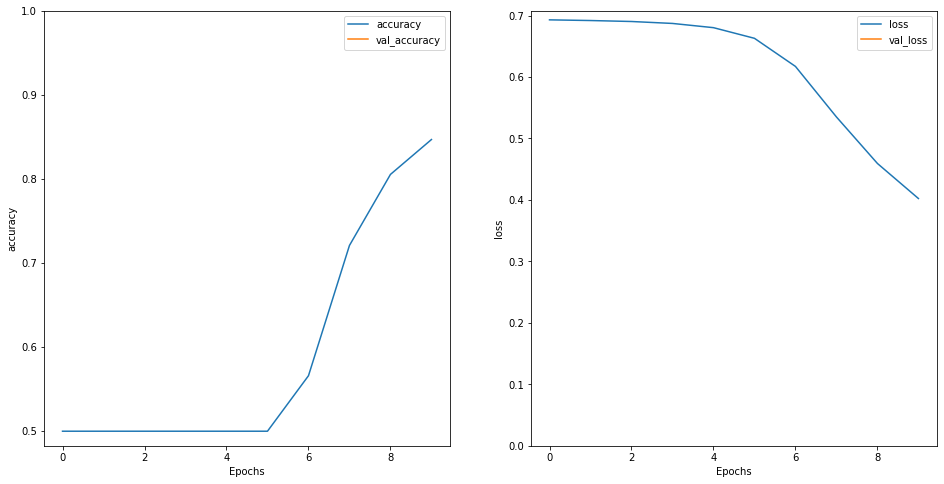

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
32/32 [==============================] - 27s 305ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/10
32/32 [==============================] - 4s 138ms/step - loss: 0.6925 - accuracy: 0.5000
Epoch 3/10
32/32 [==============================] - 5s 146ms/step - loss: 0.6915 - accuracy: 0.5000
Epoch 4/10
32/32 [==============================] - 5s 143ms/step - loss: 0.6898 - accuracy: 0.5000
Epoch 5/10
32/32 [==============================] - 4s 140ms/step - loss: 0.6845 - accuracy: 0.5000
Epoch 6/10
32/32 [==============================] - 5s 145ms/step - loss: 0.6689 - accuracy: 0.5000
Epoch 7/10
32/32 [==============================] - 5s 144ms/step - loss: 0.6226 - accuracy: 0.5215
Epoch 8/10
32/32 [==============================] - 5s 143ms/step - loss: 0.5284 - accuracy: 0.6655
Epoch 9/10
32/32 [==============================] - 4s 139ms/step - loss: 0.4519 - accuracy: 0.7365
Epoch 10/10
32/32 [==============================] - 4s 1

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

16/16 [==============================] - 0s 25ms/step - loss: 0.6122 - accuracy: 0.6570
Test Loss: 0.6122439503669739
Test Accuracy: 0.6570000052452087


In [ ]:
sample_text = ('not, buy this phone.')
predictions = model.predict(np.array([sample_text]))

if(predictions[0]>0):
  print(1)
else:
  print(0)

0


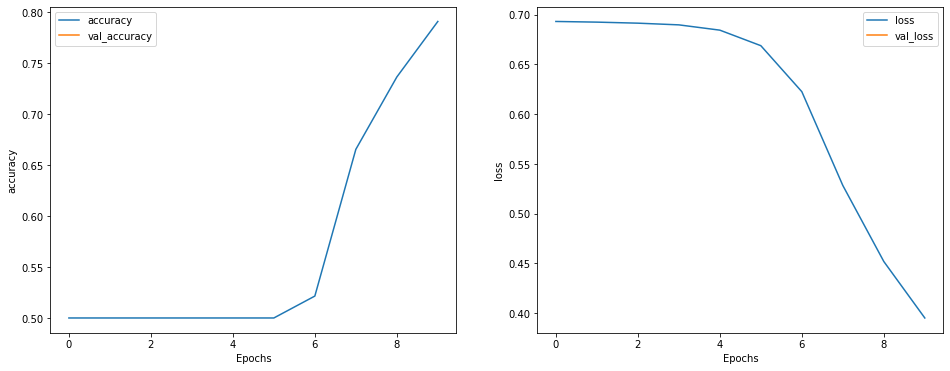

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

#Reference:
https://www.tensorflow.org/text/tutorials/text_classification_rnn#create_the_text_encoder
